In [1]:
import rebound
import reboundx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import interpolate
import matplotlib.cm as cm
import os

In [2]:
def fading_line(x, y, color='black', alpha=1, fading=True, fancy=False, **kwargs):
    try:
        from matplotlib.collections import LineCollection
        import numpy as np
    except:
        raise ImportError("Error importing matplotlib and/or numpy. Plotting functions not available. If running from within a jupyter notebook, try calling '%matplotlib inline' beforehand.")
    if "lw" not in kwargs:
        kwargs["lw"] = 1
    lw = kwargs["lw"]
    if fancy:
        kwargs["lw"] = 1*lw
        fl1 = fading_line(x, y, color=color, alpha=alpha, fading=fading, fancy=False, **kwargs)
        kwargs["lw"] = 2*lw
        alpha *= 0.5
        fl2 = fading_line(x, y, color=color, alpha=alpha, fading=fading, fancy=False, **kwargs)
        kwargs["lw"] = 6*lw
        alpha *= 0.5
        fl3 = fading_line(x, y, color=color, alpha=alpha, fading=fading, fancy=False, **kwargs)
        return [fl3,fl2,fl1]    
    Npts = len(x)
    if len(y) != Npts:
        raise AttributeError("x and y must have same dimension.")    
    #color = get_color(color)
    colors = np.zeros((Npts,4))
    colors[:,0:3] = color
    if fading:
        colors[:,3] = alpha*np.linspace(0,1,Npts)
    else:
        colors[:,3] = alpha
   
    segments = np.zeros((Npts-1,2,2))
    segments[:,0,0] = x[:-1]
    segments[:,0,1] = y[:-1]
    segments[:,1,0] = x[1:]
    segments[:,1,1] = y[1:]

    lc = LineCollection(segments, color=colors, **kwargs)
    return lc


## We can eject different particles depending on the period of the ocillation. Think this causes an instability near the SMA with the same orbital period as the oscillation

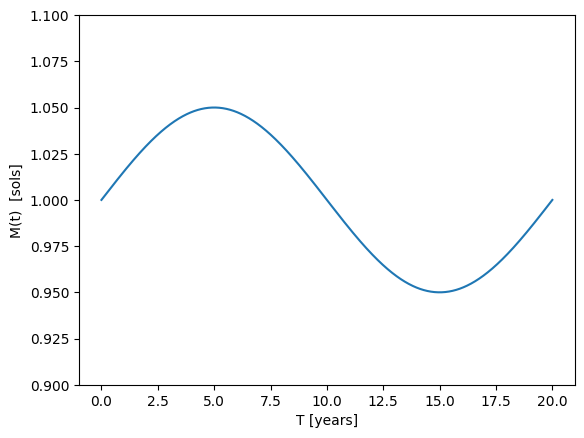

In [3]:
P=20
tgrid = np.linspace(0,P,1000)
ygrid = 1.0 + 0.05*np.sin(2*np.pi*tgrid/P)

plt.plot(tgrid,ygrid)
plt.ylabel("M(t)  [sols]")
plt.xlabel("T [years]")
plt.ylim(0.9,1.1)
plt.savefig("mass_over_time.png",dpi=300)
plt.show()

In [5]:
def add_mass(reb_sim, rebx_operator, dt):
    sim = reb_sim.contents
    sim.particles[0].m = 1.0 + 0.05*np.sin(2*np.pi*sim.t/P)

In [6]:
directory = './frames/'
if not os.path.exists(directory):
    os.makedirs(directory)

In [7]:
sim = rebound.Simulation()
sim.G = 1
sim.add(m=1.)
agrid = np.linspace(1.0,5,100)
colors = cm.jet(agrid/np.max(agrid))
for A in agrid:
    sim.add(m=0,a=A)
sim.move_to_com()  # Moves to the center of momentum frame

ps = sim.particles
periods = [ps[i].P for i in range(1,len(ps))]


sim.integrator = "ias15"
sim.dt = np.min(periods)*0.01
sim.ri_ias15.epsilon=0 #use a constant timestep


In [8]:
matplotlib.use('agg')

In [9]:
def makefig(ps,t,loc):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect("equal")
    ps = sim.particles

    # manually set plot boundaries
    lim = 6.28
    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])

    # plot the stars and planets with separate symbols
    ax.scatter(ps[0].x, ps[0].y, s=35, marker='*', facecolor='black', zorder=3)
    for i in range(1,len(ps)):
        ax.scatter(ps[i].x, ps[i].y, s=10, facecolor=colors[i-1], zorder=3)
        o = np.array(ps[i].sample_orbit(1000))
        lc = fading_line(o[:,0], o[:,1],fading=True,color=colors[i-1][:-1])
        ax.add_collection(lc)
    plt.title(r'$t/\tau$='+str(np.round(t/P,2)),fontsize=15)
    plt.savefig(loc,dpi=200)
    plt.close()

In [10]:
rebx = reboundx.Extras(sim)
myoperator = rebx.create_operator("massgrowth")
myoperator.operator_type = "updater"
myoperator.step_function = add_mass
rebx.add_operator(myoperator)

In [11]:
tstop = 1000*P
Nout = int(tstop/3)
ms = np.zeros(Nout)
a = np.zeros((sim.N,Nout))
e = np.zeros((sim.N,Nout))
x = np.zeros((sim.N,Nout))
y = np.zeros((sim.N,Nout))
vx = np.zeros((sim.N,Nout))
vy = np.zeros((sim.N,Nout))
times = np.linspace(0.,tstop,Nout)
for i, time in enumerate(times):
    makefig(sim.particles,sim.t,directory+str(i)+'.png')
    sim.integrate(time)
    ms[i] = sim.particles[0].m
    for j in range(1,sim.N):
        a[j][i] = sim.particles[j].a
        e[j][i] = sim.particles[j].e
        x[j][i] = sim.particles[j].x
        y[j][i] = sim.particles[j].y
        vx[j][i] = sim.particles[j].vx
        vy[j][i] = sim.particles[j].vy

In [12]:
Ls = []
for i in range(len(x)):
    vvec = np.array([vx[i],vy[i],np.zeros(len(vx[i]))]).T
    rvec = np.array([x[i],y[i],np.zeros(len(x[i]))]).T

    Ls.append(np.cross(rvec,vvec).T)
Ls = np.array(Ls)

In [13]:
results = [ms,a,e,x,y,vx,vy,Ls]
np.save('simulation_results.npy',results)

/home/moon/.local/lib/python3.10/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## Now do more plotting

In [36]:
matplotlib.use('module://matplotlib_inline.backend_inline')

In [15]:
periods= (2*np.pi)*a**(3/2)

/tmp/ipykernel_35831/661077105.py:1: RuntimeWarning: invalid value encountered in power
  periods= (2*np.pi)*a**(3/2)


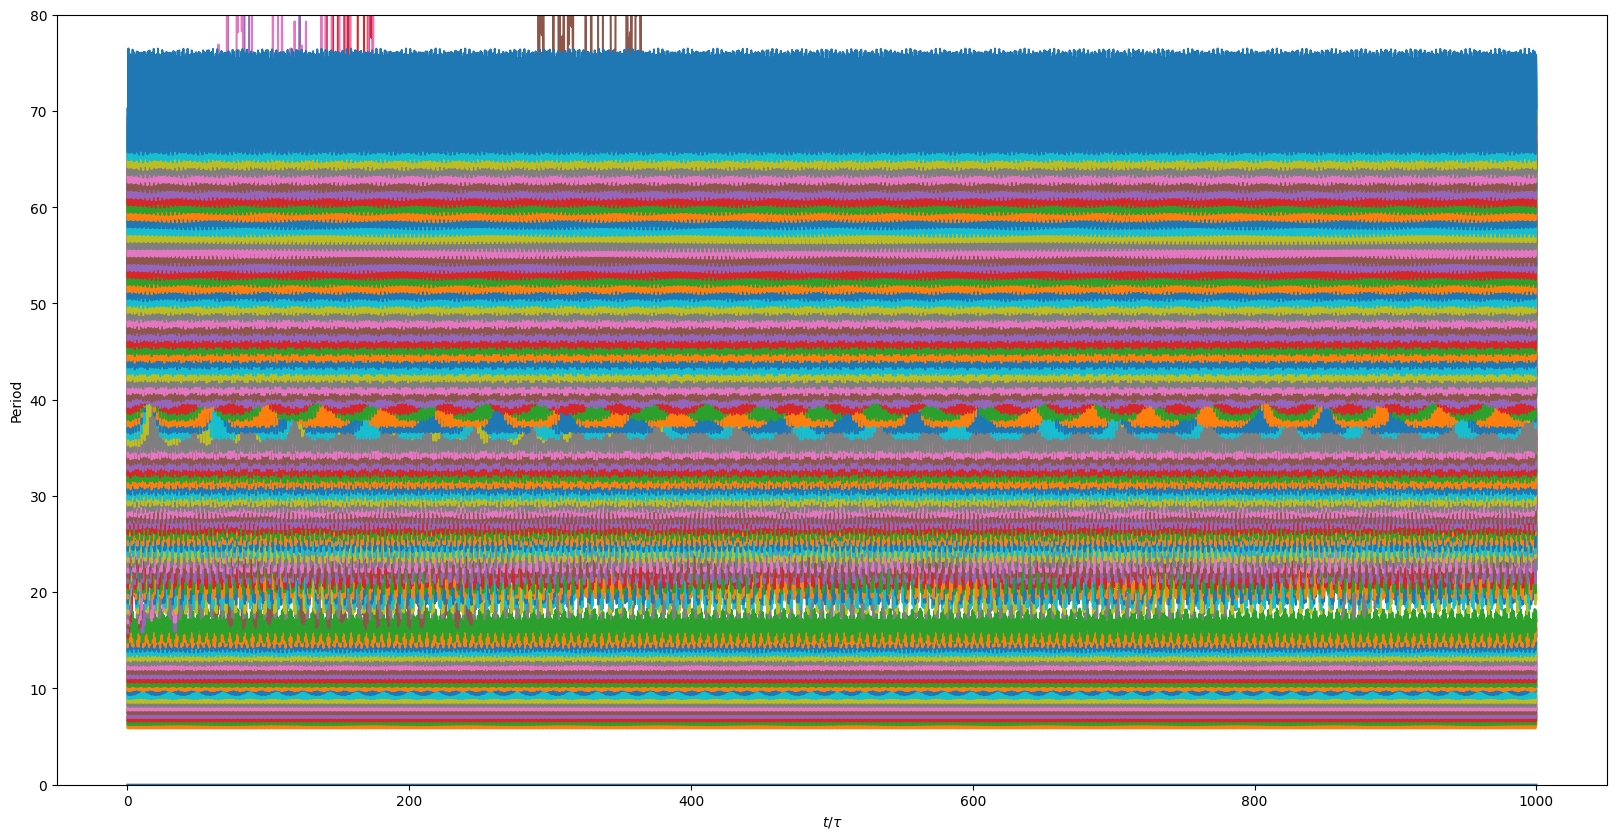

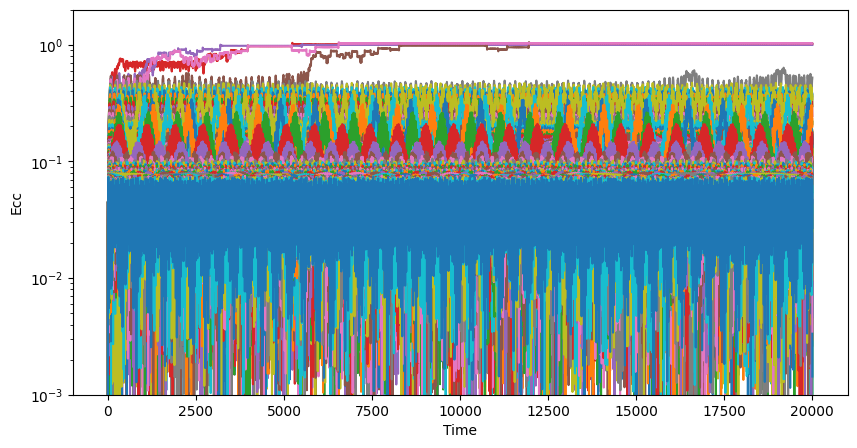

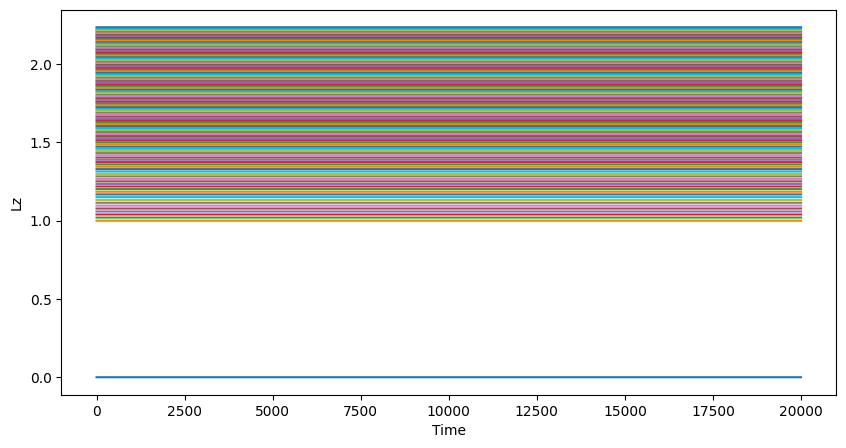

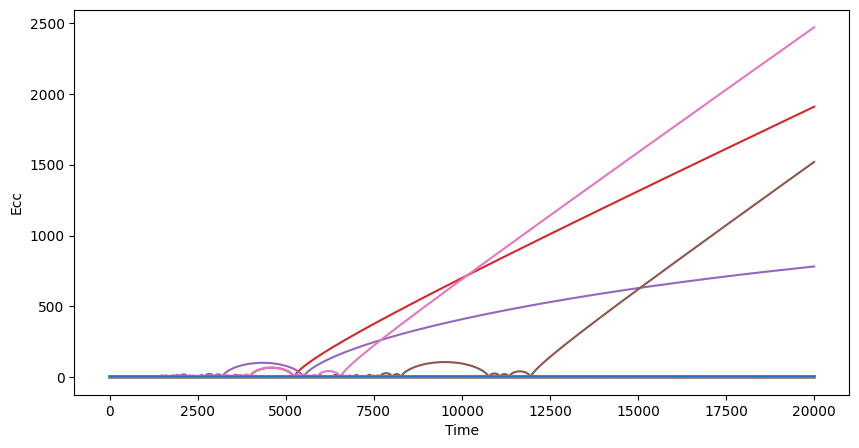

In [37]:
fig = plt.figure(figsize=(20,10))
plt.xlabel(r"$t /\tau$")
plt.ylabel("Period")
for i in range(len(a)):
    plt.plot(times/P, periods[i])
plt.ylim(0,80)
plt.savefig("periods_time.png",dpi=300)
plt.show()

fig = plt.figure(figsize=(10,5))
plt.xlabel("Time")
plt.ylabel("Ecc")
for i in range(len(e)):
    plt.plot(times, e[i])
plt.yscale('log')
plt.ylim(1e-3,2e0)
plt.show()

fig = plt.figure(figsize=(10,5))
plt.xlabel("Time")
plt.ylabel("Lz")
for i in range(len(Ls)):
    plt.plot(times, Ls[i][-1])
plt.show()


r = np.sqrt(x**2 + y**2)
fig = plt.figure(figsize=(10,5))
plt.xlabel("Time")
plt.ylabel("Ecc")
for i in range(len(r)):
    plt.plot(times, r[i])
plt.show()

## Where do the interesting guys come from?

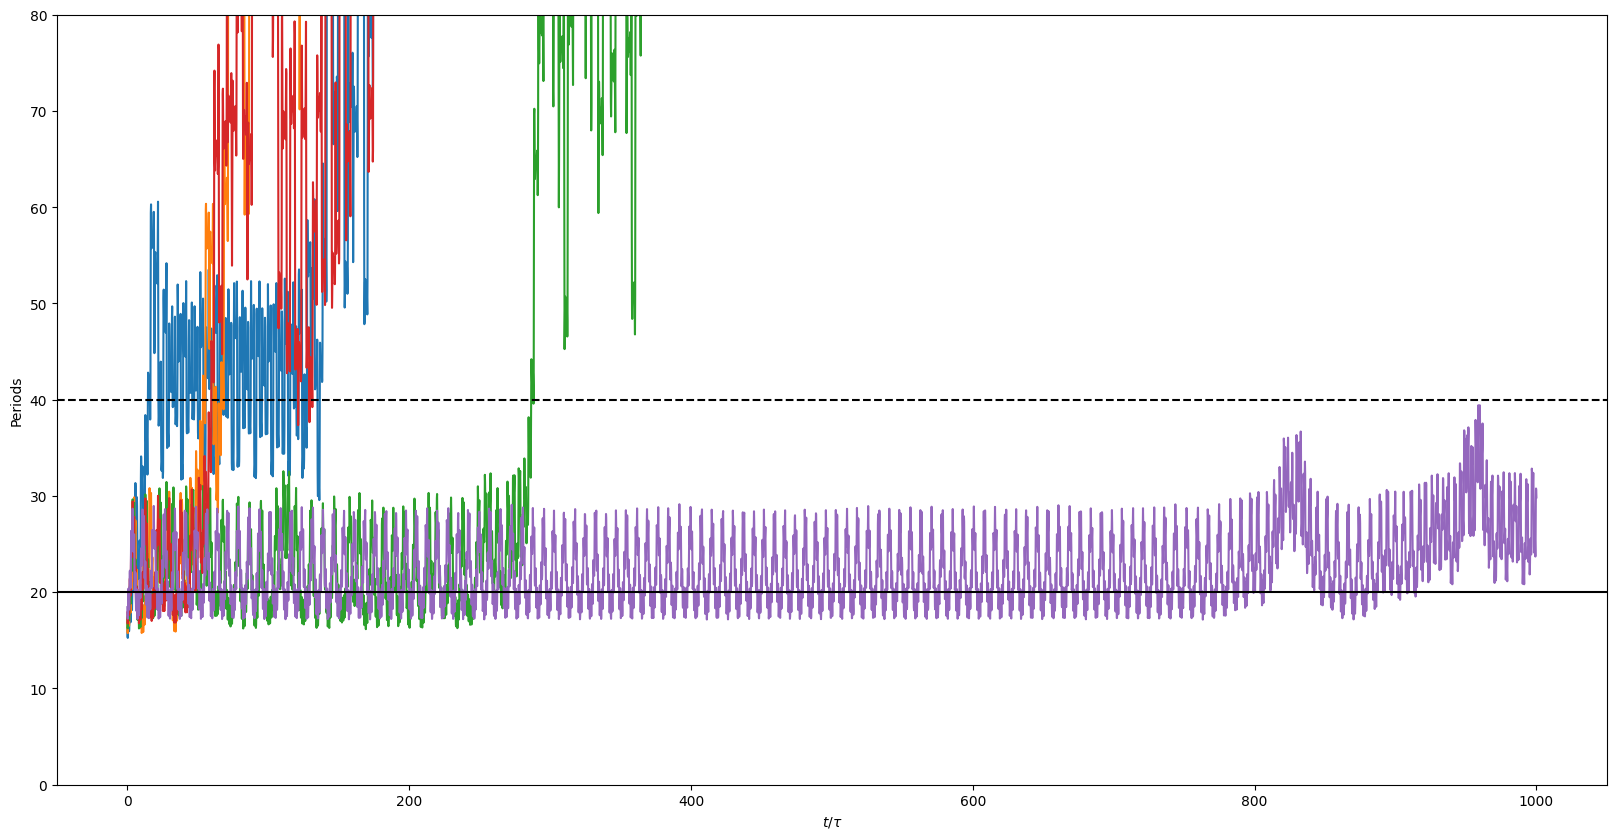

In [27]:
fig = plt.figure(figsize=(20,10))
plt.xlabel(r"$t /\tau$")
plt.ylabel("Periods")
for i in range(len(periods)):
    if np.max(e[i]) > 0.5:
        plt.plot(times/P, periods[i])
plt.axhline(P,c='k')
plt.axhline(2*P,c='k',ls='--')
plt.ylim(0,80)
plt.savefig("select_periods_time.png",dpi=300)
plt.show()

## This one is for an animation:

In [28]:
directory2 = './frames2/'
if not os.path.exists(directory2):
    os.makedirs(directory2)

In [29]:
matplotlib.use('agg')

In [31]:
for i in range(len(e.T)):
    fig = plt.figure(figsize=(10,5))
    plt.xlabel("Initial Period")
    plt.ylabel("Eccentricity")
    plt.scatter(periods.T[0][1:],e.T[i][1:],c=colors)
    plt.ylim(0,1)
    plt.xlim(0,1.05*80)
    plt.axvline(20,c='k')
    plt.axvline(10,c='k',ls='--')
    plt.axvline(40,c='k',ls='--')
    plt.title(r'$t/\tau$='+str(np.round(times[i]/P,2)),fontsize=15)
    plt.savefig(directory2+str(i)+'.png',dpi=200)
    plt.close()

    

##  Now make the animations, I want a gif and a mp4

In [32]:
import animate

In [33]:
animate.render('./frames/','coordinate_plot','gif',runtime=120,cleanup_type=None)
animate.render('./frames/','coordinate_plot','mp4',runtime=120,cleanup_type='7z')
animate.render('./frames2/','eccentricity_plot','gif',runtime=120,cleanup_type=None)
animate.render('./frames2/','eccentricity_plot','mp4',runtime=120,cleanup_type='7z')

Framerate is 55 fps
Total Runtime is 120 s


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

no cleanup type specified
Framerate is 55 fps
Total Runtime is 120 s


[libx264 @ 0x56383bdd0880] using SAR=1/1
[libx264 @ 0x56383bdd0880] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x56383bdd0880] profile High 4:4:4 Predictive, level 5.1, 4:4:4, 8-bit
[libx264 @ 0x56383bdd0880] 264 - core 163 r3060 5db6aa6 - H.264/MPEG-4 AVC codec - Copyleft 2003-2021 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=0 mixed_ref=1 me_range=16 chroma_me=1 trellis=0 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=0 chroma_qp_offset=0 threads=30 lookahead_threads=5 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc=cqp mbtree=0 qp=0
Output #0, mp4, to '../coordinate_plot.mp4':
  Metadata:
    encoder         : Lavf58.76.100
  Stream #0:0: Video: h264 (avc1 / 0x31637661), yuv444p(tv, progressive), 2000x2000 [SAR 1:1 DAR 1:1], q=2-31, 55 fps, 14080 tbn
    Metadata:
      encoder


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,20 CPUs 12th Gen Intel(R) Core(TM) i7-12700H (906A3),ASM,AES-NI)

Scanning the drive:
6666 files, 11709402745 bytes (11 GiB)

Creating archive: ../frames.7z

Items to compress: 6666


Files read from disk: 6666
Archive size: 11573710741 bytes (11 GiB)
Everything is Ok
no cleanup type specified
Framerate is 55 fps
Total Runtime is 120 s


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

no cleanup type specified
Framerate is 55 fps
Total Runtime is 120 s


frame= 6666 fps=105 q=-1.0 Lsize=  176784kB time=00:02:01.18 bitrate=11950.8kbits/s speed=1.91x    
video:176755kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.016242%
[libx264 @ 0x559e0d9cbb80] frame I:27    Avg QP: 0.00  size: 43073
[libx264 @ 0x559e0d9cbb80] frame P:6639  Avg QP: 0.00  size: 27088
[libx264 @ 0x559e0d9cbb80] mb I  I16..4: 82.2% 11.3%  6.6%
[libx264 @ 0x559e0d9cbb80] mb P  I16..4:  1.3%  0.1%  0.8%  P16..4:  1.8%  0.9%  0.8%  0.0%  0.0%    skip:94.4%
[libx264 @ 0x559e0d9cbb80] 8x8 transform intra:4.6% inter:10.2%
[libx264 @ 0x559e0d9cbb80] coded y,u,v intra: 24.2% 22.4% 22.5% inter: 1.8% 1.8% 1.8%
[libx264 @ 0x559e0d9cbb80] i16 v,h,dc,p: 78% 22%  0%  0%
[libx264 @ 0x559e0d9cbb80] i8 v,h,dc,ddl,ddr,vr,hd,vl,hu: 11%  7% 81%  0%  0%  0%  0%  0%  0%
[libx264 @ 0x559e0d9cbb80] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 34% 30% 20%  3%  3%  2%  3%  2%  2%
[libx264 @ 0x559e0d9cbb80] Weighted P-Frames: Y:0.0% UV:0.0%
[libx264 @ 0x559e0d9cbb80] ref P L0: 


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,20 CPUs 12th Gen Intel(R) Core(TM) i7-12700H (906A3),ASM,AES-NI)

Scanning the drive:
6666 files, 490814226 bytes (469 MiB)

Creating archive: ../frames2.7z

Items to compress: 6666


Files read from disk: 6666
Archive size: 351491934 bytes (336 MiB)
Everything is Ok
no cleanup type specified
